In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm


In [18]:
data_dir = "/home/parth/snaak/snaak_data/data_parth/"
# session_dir = os.path.join(data_dir, os.listdir(data_dir)[0])
session_dir = os.path.join(data_dir, "10_19_21_13_38")
episode_data_path = os.path.join(session_dir, "11.npz")
print(episode_data_path)

/home/parth/snaak/snaak_data/data_parth/10_19_21_13_38/11.npz


In [19]:
# Read npz file
data = np.load(episode_data_path, allow_pickle=True)
print(data.files)
rgb = data['rgb']  # Shape: (T, H, W, 3)
depth = data['depth']  # Shape: (T, H, W)
action = data['a1']  # Shape: (T, action_dim)
start_weight = data['start_weight']  # Shape: (T,)

['rgb', 'depth', 'start_weight', 'final_weight', 'z_below_surface', 'a1']


In [20]:
# cv2.imwrite("rgb_image.jpg", cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR))
# np.save("depth_map.npy", depth)

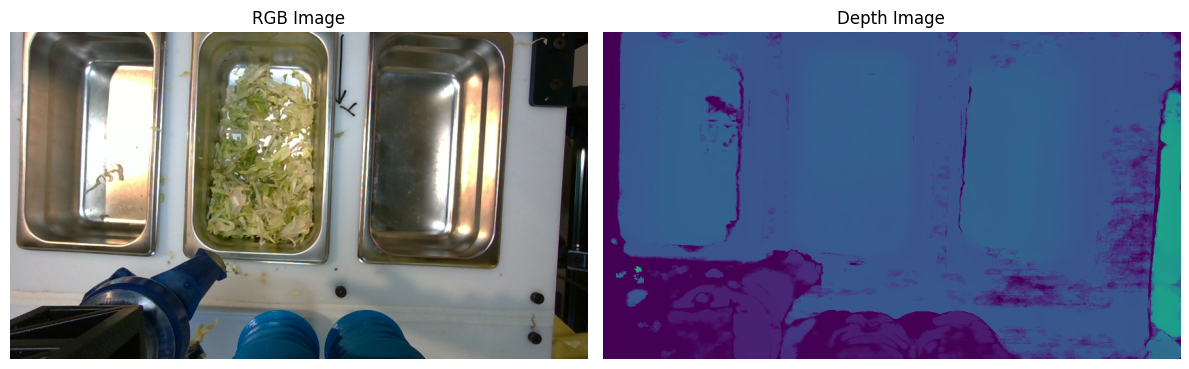

Action:  [ 0.011 -0.052 -0.065]
Start Weight:  -92.0
Depth shape:  (480, 848)
RGB shape:  (480, 848, 3)


In [21]:
# Plot rgb and depth side by side using matplotlib
plt.figure(figsize=(12, 6))

# RGB image
plt.subplot(1, 2, 1)
plt.imshow(rgb)
plt.title("RGB Image")
plt.axis('off')

# Depth image
plt.subplot(1, 2, 2)
plt.imshow(depth)
plt.title("Depth Image")
plt.axis('off')

plt.tight_layout()
plt.show()

print("Action: ", action)
print("Start Weight: ", start_weight)
print("Depth shape: ", depth.shape)
print("RGB shape: ", rgb.shape)

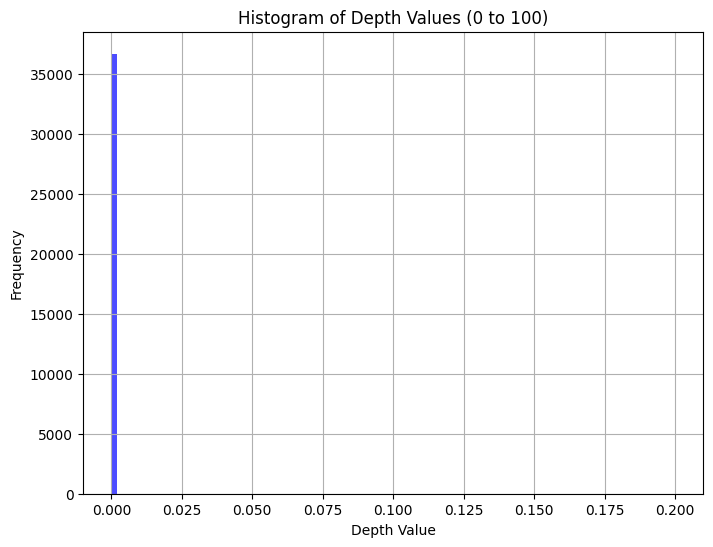

In [6]:
# Select depth between 0 to 100 and show the historgram of the depth values
plt.figure(figsize=(8, 6))
plt.hist(depth.flatten(), bins=100, range=(0, 0.2), color='blue', alpha=0.7)
plt.title("Histogram of Depth Values (0 to 100)")
plt.xlabel("Depth Value")
plt.ylabel("Frequency")
plt.grid()
plt.show()

In [7]:
# Save the rgb image as jpg
cv2.imwrite("rgb_image.jpg", cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR))

True

In [8]:
# Crop coordinates
# Top left: 60, 184
# Top right: 412, 161
# Bottom left: 71, 398
# Bottom right: 426, 377

pts_src = np.array([
    [270, 0],
    [465, 0],
    [270, 330],
    [456, 330],
], dtype=np.float32)

# Define destination points (rectangle)
# Width = distance between top-left and top-right
# Height = distance between top-left and bottom-left
# width = int(np.linalg.norm(pts_src[0] - pts_src[1]))
# height = int(np.linalg.norm(pts_src[0] - pts_src[3]))

# pts_dst = np.array([
#     [0, 0],
#     [width - 1, 0],
#     [width - 1, height - 1],
#     [0, height - 1]
# ], dtype=np.float32)

# # Compute perspective transform
# M = cv2.getPerspectiveTransform(pts_src, pts_dst)

# # Warp the image to get the cropped rectangle
# cropped = cv2.warpPerspective(rgb, M, (width, height))

# Crop the image given these points
cropped_rgb = rgb[0:330, 270:465, :]
cropped_depth = depth[0:330, 270:465]

# TODO: Need to rotate the bin to make it axis aligned

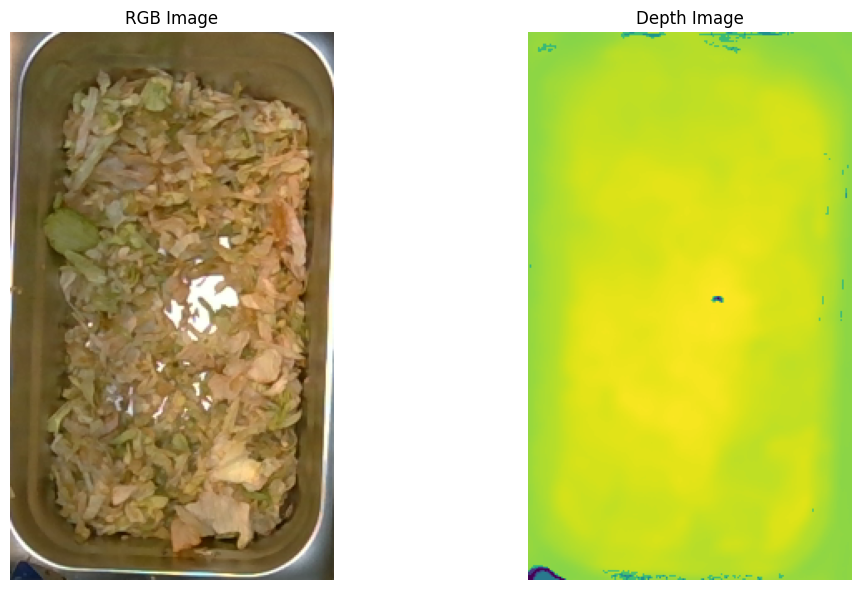

Action:  [-0.03628063 -0.06308496 -0.046     ]
Start Weight:  128.0
Depth shape:  (480, 848)
RGB shape:  (480, 848, 3)


In [9]:
plt.figure(figsize=(12, 6))

# RGB image
plt.subplot(1, 2, 1)
plt.imshow(cropped_rgb)
plt.title("RGB Image")
plt.axis('off')

# Depth image
plt.subplot(1, 2, 2)
plt.imshow(cropped_depth, cmap='viridis')
plt.title("Depth Image")
plt.axis('off')

plt.tight_layout()
plt.show()

print("Action: ", action)
print("Start Weight: ", start_weight)
print("Depth shape: ", depth.shape)
print("RGB shape: ", rgb.shape)

Action in pixels:  147 251


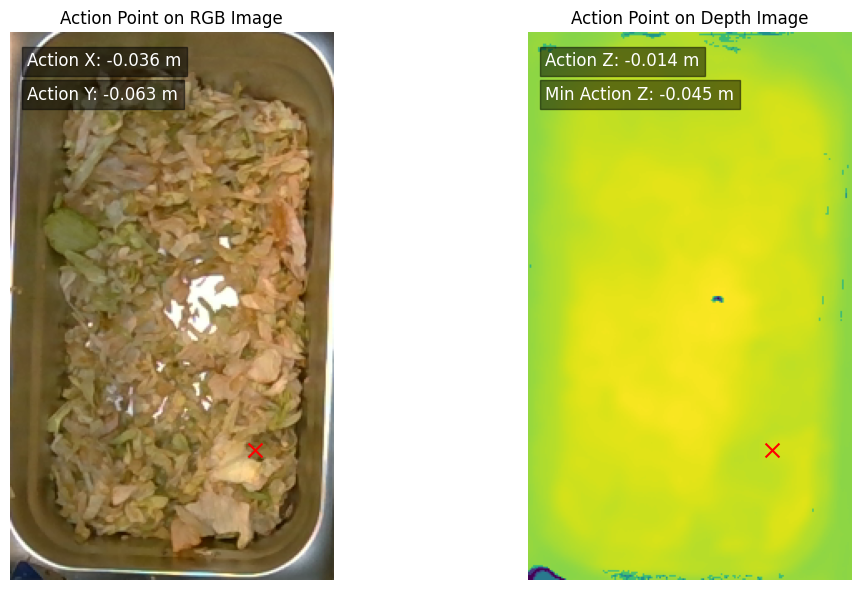

In [10]:
# Converting pickup XY from Bin to pixel coordinates

bin_height_pix = 330
bin_width_pix = 195

bin_height_m = 0.240
bin_width_m = 0.140

bin_height_m2pix = bin_height_pix / bin_height_m
bin_width_m2pix = bin_width_pix / bin_width_m

action_xm = action[0]
action_ym = action[1]

action_xpix = int(action_xm * bin_width_m2pix)
action_ypix = int(action_ym * bin_height_m2pix)

bin_center_xpix = bin_width_pix // 2
bin_center_ypix = bin_height_pix // 2

action_xpix = bin_center_xpix - action_xpix
action_ypix = bin_center_ypix - action_ypix

# Temporary values
# action_xpix = bin_center_xpix
# action_ypix = bin_center_ypix - 80

print("Action in pixels: ", action_xpix, action_ypix)

# Get depth at action point
depth_wrt_cam = cropped_depth[action_ypix, action_xpix] # mm
dist_cam2bintop = 325 # mm
min_action_z = -45 # mm

action_z = dist_cam2bintop - depth_wrt_cam
action_z += 20 # Correction for weird descrepancy in data collection in manipulation


# Convert mm to m
action_z /= 1000.0
min_action_z /= 1000.0


plt.figure(figsize=(12, 6))

# Cropped RGB image with action point
plt.subplot(1, 2, 1)
plt.imshow(cropped_rgb)
plt.scatter(action_xpix, action_ypix, c='red', s=100, marker='x')
plt.title("Action Point on RGB Image")
plt.axis('off')
plt.text(10, 20, f"Action X: {action[0]:.3f} m", color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
plt.text(10, 40, f"Action Y: {action[1]:.3f} m", color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))

# Cropped Depth image with action point
plt.subplot(1, 2, 2)
plt.imshow(cropped_depth, cmap='viridis')
plt.scatter(action_xpix, action_ypix, c='red', s=100, marker='x')
plt.title("Action Point on Depth Image")
plt.axis('off')
plt.text(10, 20, f"Action Z: {action_z:.3f} m", color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
plt.text(10, 40, f"Min Action Z: {min_action_z:.3f} m", color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))

plt.tight_layout()
plt.show()

In [18]:
def extract_rgbd_from_data(data_path, rgb_save_dir, depth_save_dir):
    session_files = sorted(os.listdir(data_path))
    for session_file in tqdm(session_files, desc="Sessions"):
        session_data_path = os.path.join(data_path, session_file)
        episode_files = sorted(os.listdir(session_data_path))
        for episode_file in episode_files:
            episode_data_path = os.path.join(session_data_path, episode_file)
            data = np.load(episode_data_path, allow_pickle=True)
            rgb = data['rgb']
            depth = data['depth']

            rgb = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)

            rgb_name = f"s{session_file}_e{episode_file.split('.')[0]}_rgb.jpg"
            depth_name = f"s{session_file}_e{episode_file.split('.')[0]}_depth.npy"

            rgb_save_path = os.path.join(rgb_save_dir, rgb_name)
            depth_save_path = os.path.join(depth_save_dir, depth_name)

            # print(rgb_save_path)
            # print(depth_save_path)

            cv2.imwrite(rgb_save_path, rgb)
            np.save(depth_save_path, depth)


In [19]:
data_path = "/home/parth/snaak/snaak_data/data_parth"
rgb_save_dir = "/home/parth/snaak/snaak_data/extracted/rgb"
depth_save_dir = "/home/parth/snaak/snaak_data/extracted/depth"

extract_rgbd_from_data(data_path, rgb_save_dir, depth_save_dir)

Sessions: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]
